In [1]:
# !pip install backtrader
# !pip install yfinance --upgrade --no-cache-dir
# !pip install ipympl
# !pip install ipywidgets

In [2]:
import datetime
from model import volatility
from model import trading_intensity
from model import AvellanedaStoikov
import pandas as pd
import numpy as np
orderbook_df = pd.read_csv ('Data/historical_ETHUSDT_orderbook_data.csv')
kline_full_df = pd.read_csv('Data/historical_ETHUSDT_kline_data.csv')

kline_next_df = kline_full_df.copy()
kline_next_df['Datetime'] = kline_next_df['Datetime'].apply(lambda x: datetime.datetime.fromtimestamp(int(x) / 1000) )    

kline_reduced_array = []

for datetime in np.unique( kline_full_df['Datetime'].tolist() ):
    kline_reduced_array.append( kline_next_df[kline_full_df['Datetime'] == datetime].tail(1) )

kline_next_df = pd.concat(kline_reduced_array, axis=0)

kline_next_df.set_index('Datetime', inplace=True)

kline_next_df.head()

,Open,High,Low,Close,Volume
Datetime,,,,,
2024-03-14 23:14:00,3753.36,3753.96,3747.97,3752.54,3437.220
2024-03-14 23:15:00,3752.54,3766.51,3749.00,3765.91,5230.063
2024-03-14 23:16:00,3765.91,3767.97,3762.01,3762.01,3524.484
2024-03-14 23:17:00,3762.01,3762.01,3748.39,3753.72,7196.243
2024-03-14 23:18:00,3753.72,3755.63,3749.49,3749.50,6817.658


In [3]:
kline_next_df.tail()

,Open,High,Low,Close,Volume
Datetime,,,,,
2024-03-15 19:06:00,3720.07,3720.67,3714.00,3716.90,1698.676
2024-03-15 19:07:00,3716.90,3718.89,3714.49,3715.70,2018.968
2024-03-15 19:08:00,3715.71,3719.50,3715.45,3719.01,826.575
2024-03-15 19:09:00,3719.00,3724.00,3719.00,3723.22,747.899
2024-03-15 19:10:00,3723.22,3724.82,3719.48,3722.43,1139.199


In [4]:
kline_full_df.head()

,Datetime,Open,High,Low,Close,Volume
0,1710472440000,3753.36,3753.96,3748.6,3749.64,1039.917
1,1710472440000,3753.36,3753.96,3748.6,3749.65,1067.768
2,1710472440000,3753.36,3753.96,3748.6,3749.65,1068.247
3,1710472440000,3753.36,3753.96,3748.6,3749.69,1102.720
4,1710472440000,3753.36,3753.96,3748.6,3749.69,1109.573


In [5]:
orderbook_df.head()

,Datetime,bidp0,bidp1,bidp2,bidp3,bidp4,bidp5,bidp6,bidp7,bidp8,...,askv0,askv1,askv2,askv3,askv4,askv5,askv6,askv7,askv8,askv9
0,1710472459391,3749.71,3749.70,3749.69,3749.67,3749.65,3749.64,3749.60,3749.58,3749.57,...,14.474,0.006,0.007,0.540,0.053,0.266,0.948,2.000,0.053,0.014
1,1710472459509,3749.71,3749.70,3749.69,3749.67,3749.65,3749.64,3749.60,3749.58,3749.57,...,15.250,0.006,0.007,0.540,0.053,0.266,0.948,2.000,0.053,0.021
2,1710472459616,3749.64,3749.61,3749.60,3749.57,3749.56,3749.55,3749.53,3749.52,3749.50,...,23.221,2.000,5.289,18.722,0.006,0.533,0.007,0.266,0.053,0.540
3,1710472459726,3749.64,3749.63,3749.60,3749.57,3749.56,3749.55,3749.53,3749.52,3749.50,...,51.798,2.000,0.007,8.033,0.533,0.007,0.266,0.053,0.540,0.053
4,1710472459833,3749.46,3749.44,3749.43,3749.42,3749.37,3749.34,3749.32,3749.29,3749.27,...,10.347,0.053,0.010,0.053,1.439,0.180,15.903,2.475,6.432,0.533


In [11]:
# https://blog.quantinsti.com/backtrader/

# exp1
# k multipler = 1000, risk_avesion = 0.1

k_multiplier = 1000
risk_aversion = 0.1

import datetime
import backtrader as bt
import yfinance as yf

from backtrader import Order

def str_to_timestamp( s ):
    return int( datetime.datetime.strptime(s, '%Y-%m-%d %H:%M:%S').timestamp() * 1000 )

orderbook_timestamp = orderbook_df['Datetime'].tolist()

def smallest_timestamp_before( t ):
    for i in range(len(orderbook_timestamp)):
        if orderbook_timestamp[i] > t:
            return int(orderbook_timestamp[i-1])

def time_percentage( t ):
    start_time = kline_full_df.iloc[1]['Datetime']
    end_time = kline_full_df.iloc[-1]['Datetime']
    time_diff = end_time - start_time
    return (t - start_time ) /(end_time - start_time)

class MAstrategy(bt.Strategy):
    def __init__(self):
        self.orders = []

    def next(self):
        time = str_to_timestamp( str( self.datas[0].datetime.date() ) + " " + str( self.data.datetime.time() )   )  
        start_time = kline_full_df.iloc[1]['Datetime']
        end_time = kline_full_df.iloc[-1]['Datetime']
        
        if start_time >= time:
            return

        if end_time <= time:
            return
        
        ask_price_at_time = orderbook_df[orderbook_df["Datetime"] == smallest_timestamp_before(  time	)].iloc[0] ['askp0']
        bid_price_at_time = orderbook_df[orderbook_df["Datetime"] == smallest_timestamp_before(  time	)].iloc[0] ['bidp0']
        
        s = 0.5 * ( ask_price_at_time + bid_price_at_time )

        sigma = volatility(kline_full_df , time)

        k = trading_intensity(orderbook_df , time)

        eta = 0.005
        
        gamma = risk_aversion

        qt = self.position.size
        
        AS = AvellanedaStoikov(s, qt, sigma, gamma, k * k_multiplier , eta , 1 , time_percentage(time) )

        if k > 0 :
            for order in self.orders:
                self.broker.cancel(order)
            self.log('Buy Limit Create, %.2f' % AS.optimal_bid())
            order = self.buy(exectype=Order.Limit, price=AS.optimal_bid() , size=AS.bid_size(qt , self.stats.broker.value[0] * 0.5) )
            self.log('Sell Limit Create, %.2f' % AS.optimal_ask())
            order = self.sell(exectype=Order.Limit, price=AS.optimal_ask() , size=AS.bid_size(qt , self.stats.broker.value[0] * 0.5) )
            self.log('Account Value, %.2f' % self.stats.broker.value[0] )
 
	# outputting information
    def log(self, txt):
        dt = str( self.datas[0].datetime.date() ) + " " + str( self.data.datetime.time() )
        print('%s, %s' % (dt, txt))
    
    def notify_order(self, order):
        if order.status == order.Completed:
            if order.isbuy():
                self.log(
                "Executed Limit BUY (Price: %.2f, Value: %.2f, Commission %.2f)" %
                (order.executed.price, order.executed.value, order.executed.comm))
            else:
                self.log(
                "Executed Limit SELL (Price: %.2f, Value: %.2f, Commission %.2f)" %
                (order.executed.price, order.executed.value, order.executed.comm))
            self.bar_executed = len(self)
        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log("Order was canceled/margin/rejected")

cerebro = bt.Cerebro()
cerebro.addstrategy(MAstrategy)
cerebro.broker.setcash(10000)
cerebro.broker.setcommission(commission=0.000 , leverage=10)
data = bt.feeds.PandasData(dataname=kline_next_df )
cerebro.adddata(data)
   
print('<START> Brokerage account: $%.2f' % cerebro.broker.getvalue())
cerebro.run()
print('<FINISH> Brokerage account: $%.2f' % cerebro.broker.getvalue())
%matplotlib inline
# Plot the strategy
img = cerebro.plot(style='candlestick',loc='grey', grid=False, iplot=False) #You can leave inside the paranthesis empty

img[0][0].savefig('Data/plot_k_multiplier{}_risk_aversion{}.png'.format(k_multiplier , risk_aversion))

<START> Brokerage account: $10000.00
2024-03-14 23:18:00, Buy Limit Create, 3752.93
2024-03-14 23:18:00, Sell Limit Create, 3753.28
2024-03-14 23:18:00, Account Value, 10000.00
2024-03-14 23:19:00, Executed Limit BUY (Price: 3749.49, Value: 3749.49, Commission 0.00)
2024-03-14 23:19:00, Buy Limit Create, 3749.45
2024-03-14 23:19:00, Sell Limit Create, 3749.51
2024-03-14 23:19:00, Account Value, 10000.00
2024-03-14 23:20:00, Executed Limit BUY (Price: 3746.00, Value: 4970.48, Commission 0.00)
2024-03-14 23:20:00, Buy Limit Create, 3745.14
2024-03-14 23:20:00, Sell Limit Create, 3746.76
2024-03-14 23:20:00, Account Value, 9996.51
2024-03-14 23:21:00, Executed Limit BUY (Price: 3739.04, Value: 4932.39, Commission 0.00)
2024-03-14 23:22:00, Buy Limit Create, 3720.38
2024-03-14 23:22:00, Sell Limit Create, 3720.47
2024-03-14 23:22:00, Account Value, 9914.29
2024-03-14 23:23:00, Executed Limit BUY (Price: 3720.38, Value: 4867.59, Commission 0.00)
2024-03-14 23:23:00, Executed Limit SELL (Pri

600 0.01 :
<FINISH> Brokerage account: $12791.88


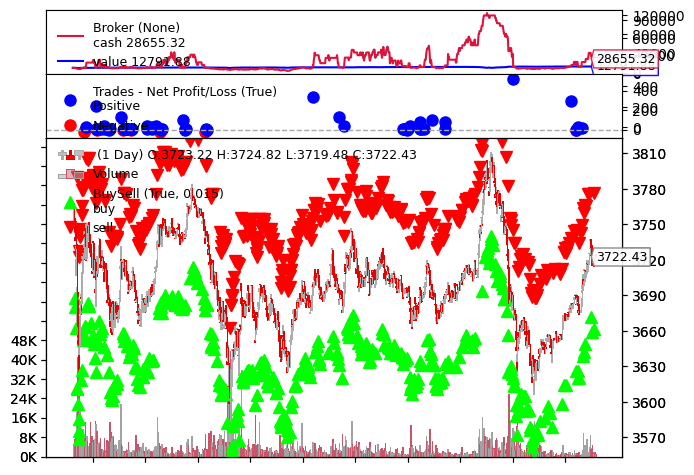

600 0.05 :
<FINISH> Brokerage account: $12572.35


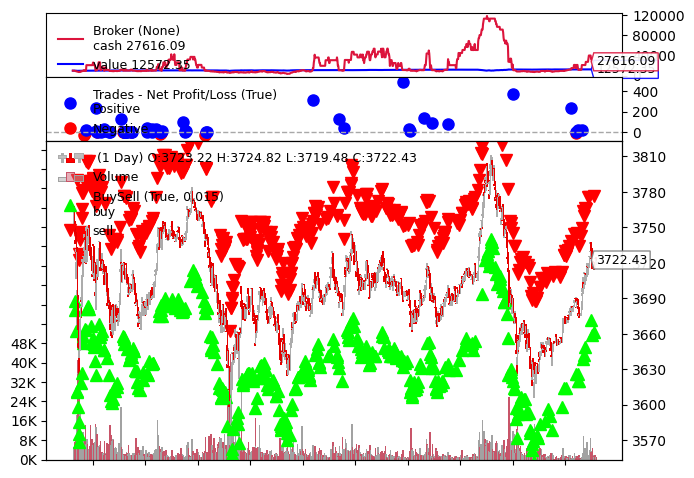

600 0.1 :
<FINISH> Brokerage account: $12470.59


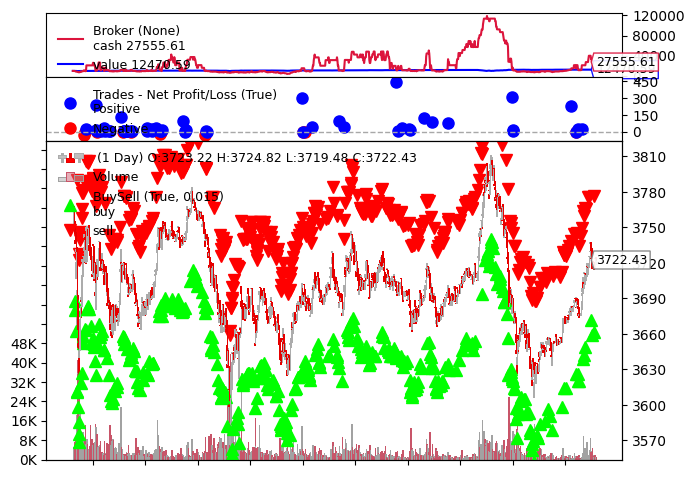

600 0.5 :
<FINISH> Brokerage account: $16133.93


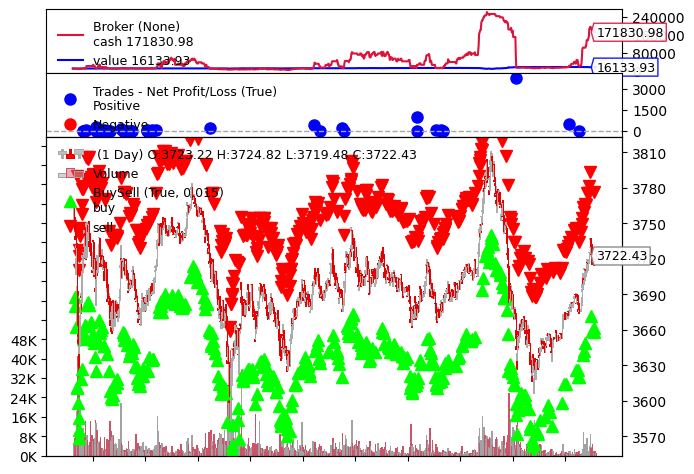

600 1 :
<FINISH> Brokerage account: $13328.98


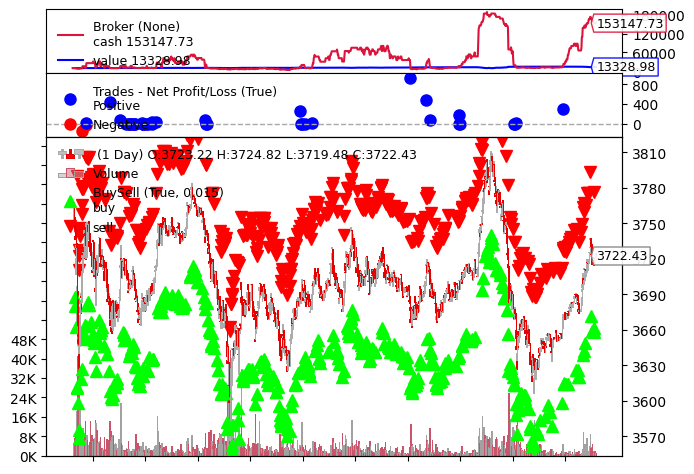

800 0.01 :
<FINISH> Brokerage account: $12537.48


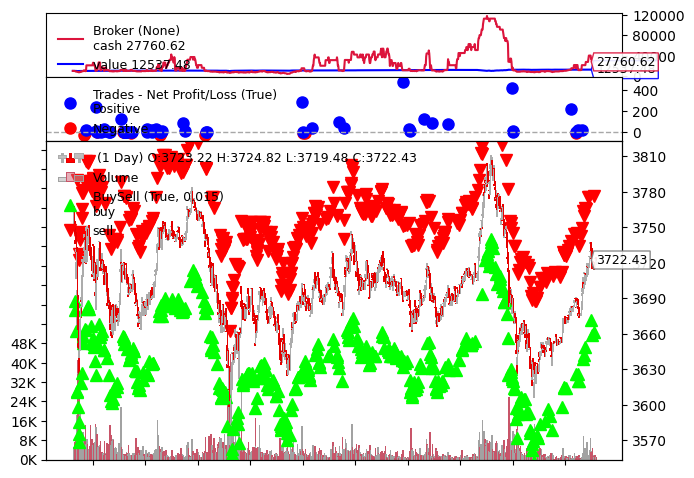

800 0.05 :
<FINISH> Brokerage account: $12386.26


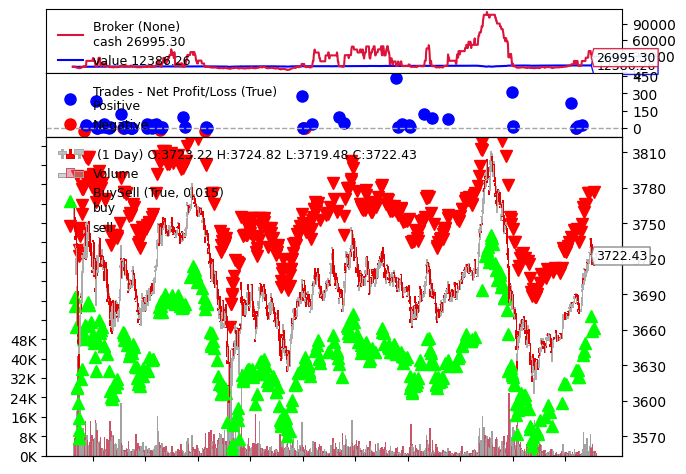

800 0.1 :
<FINISH> Brokerage account: $12303.70


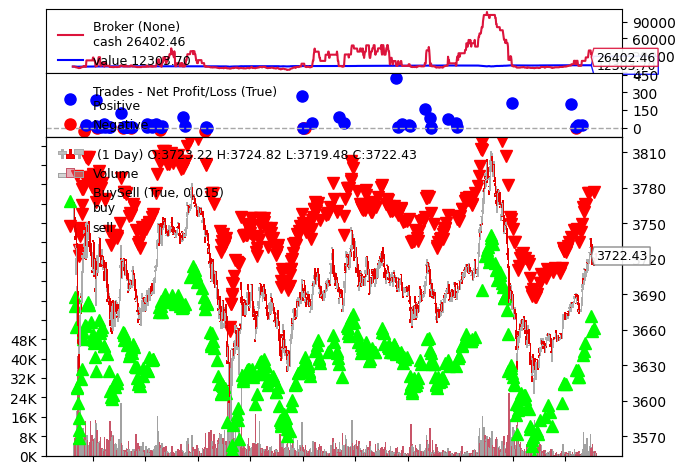

800 0.5 :
<FINISH> Brokerage account: $16067.23


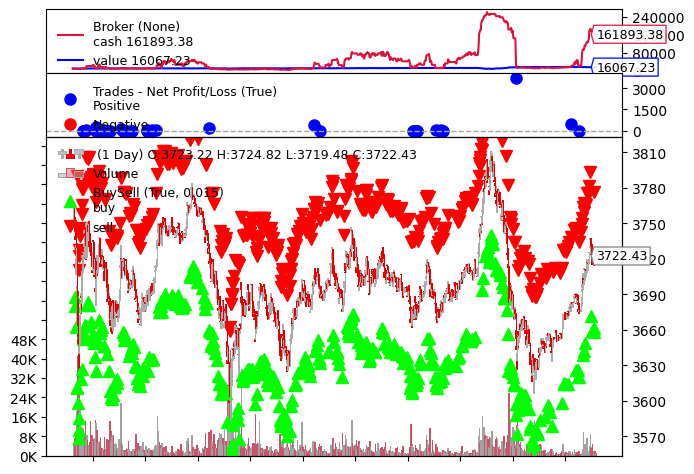

800 1 :
<FINISH> Brokerage account: $13231.14


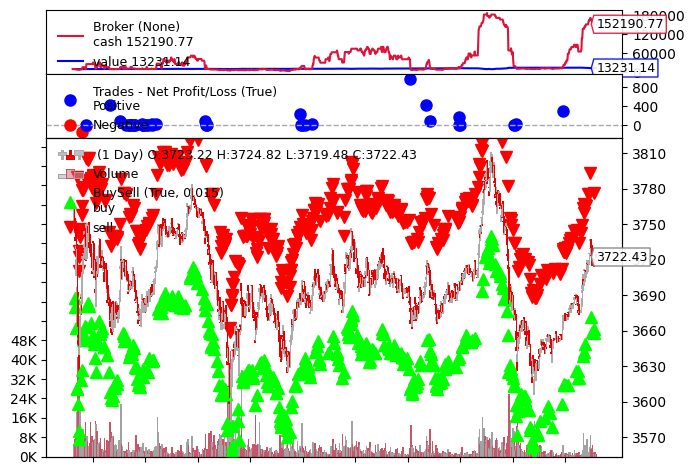

1000 0.01 :
<FINISH> Brokerage account: $12485.11


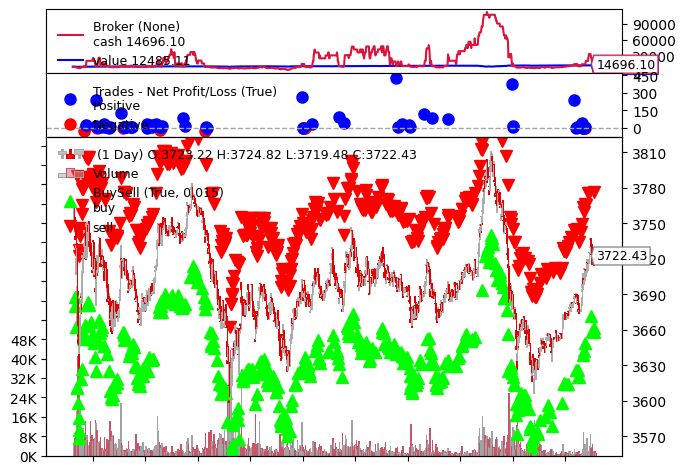

1000 0.05 :
<FINISH> Brokerage account: $12367.92


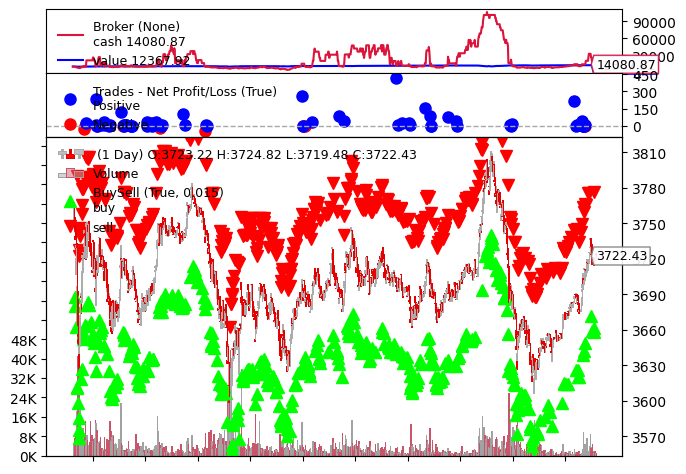

1000 0.1 :
<FINISH> Brokerage account: $12553.17


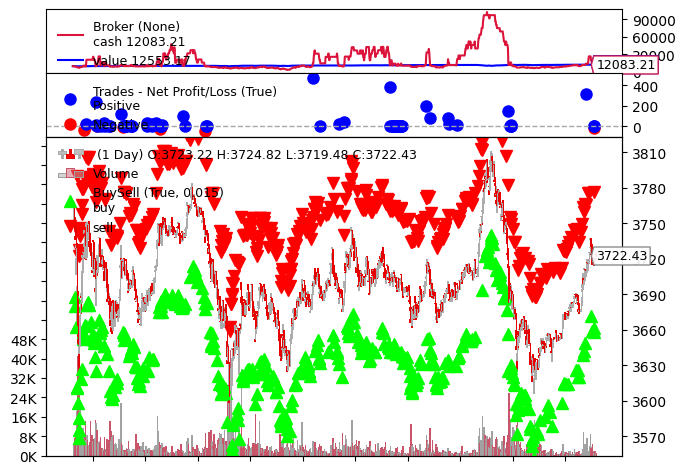

1000 0.5 :
<FINISH> Brokerage account: $15969.46


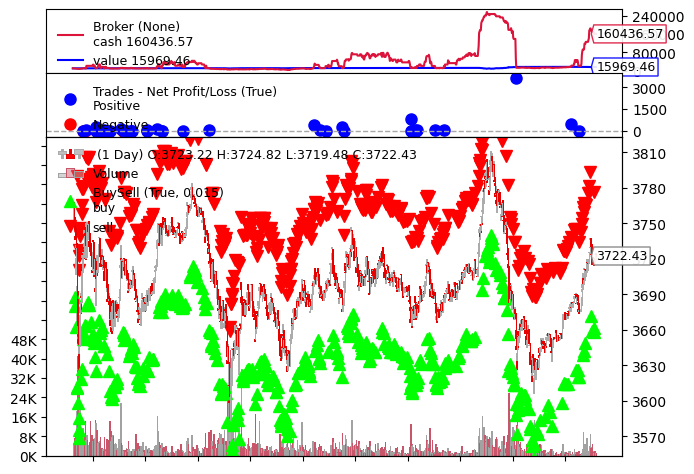

1000 1 :
<FINISH> Brokerage account: $13158.58


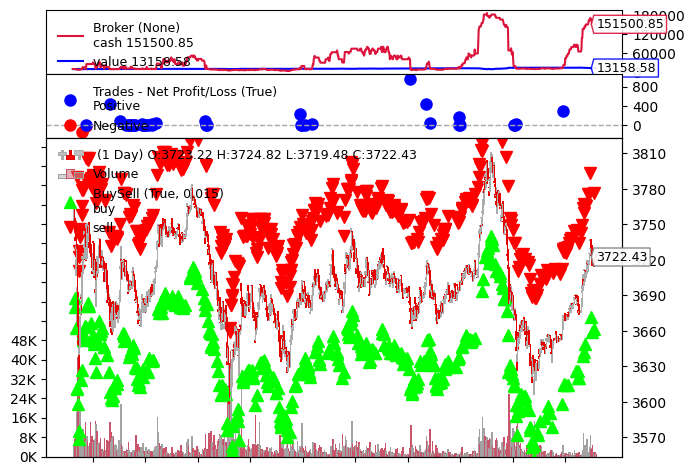

1200 0.01 :
<FINISH> Brokerage account: $12426.75


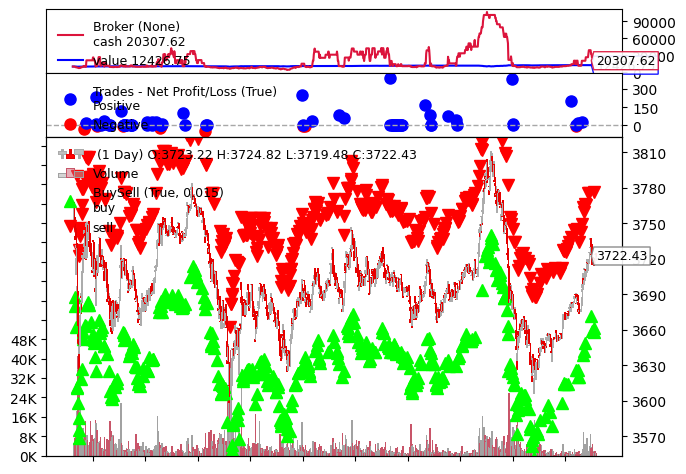

1200 0.05 :
<FINISH> Brokerage account: $12336.25


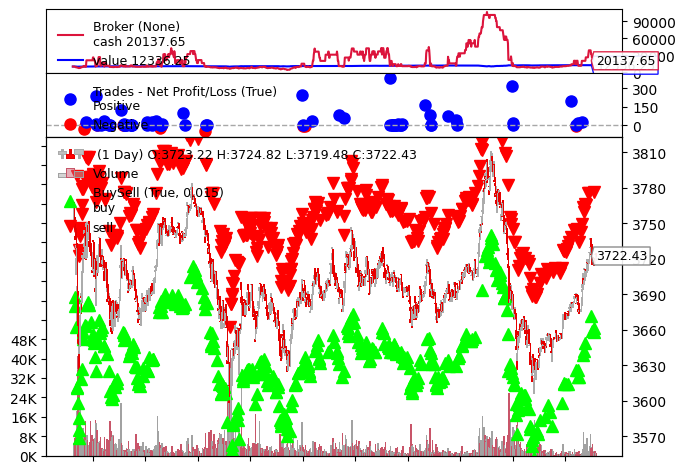

1200 0.1 :
<FINISH> Brokerage account: $12774.23


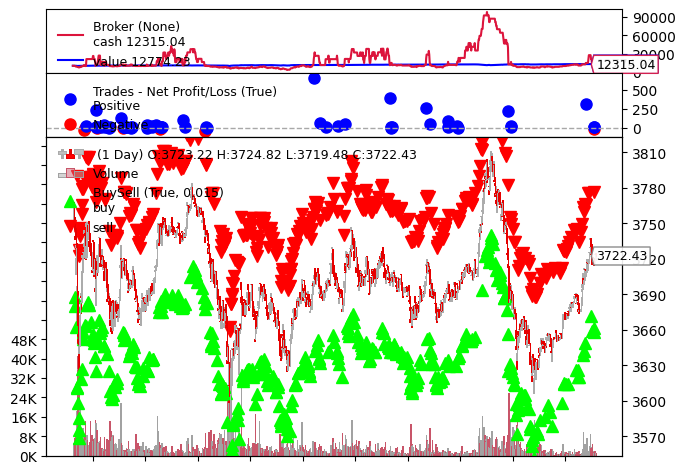

1200 0.5 :
<FINISH> Brokerage account: $15873.86


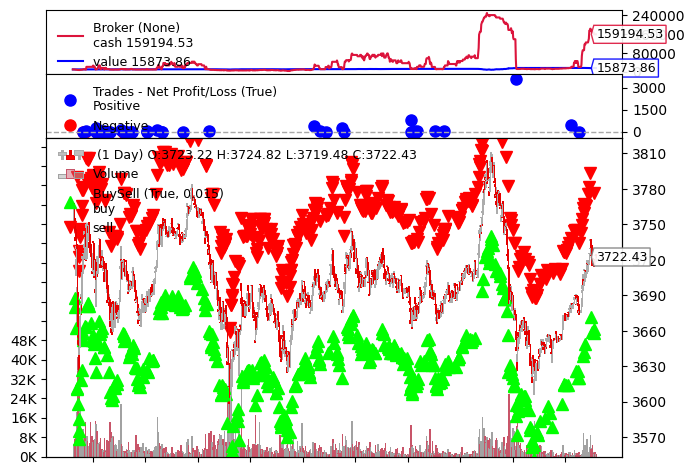

1200 1 :
<FINISH> Brokerage account: $13107.50


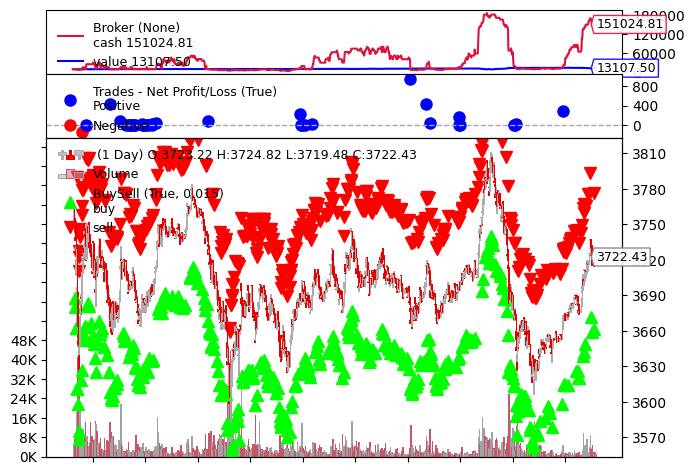

1400 0.01 :
<FINISH> Brokerage account: $12354.55


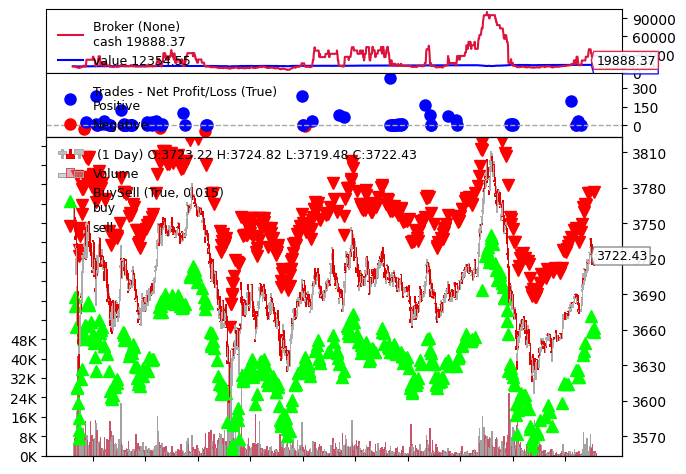

1400 0.05 :
<FINISH> Brokerage account: $12279.28


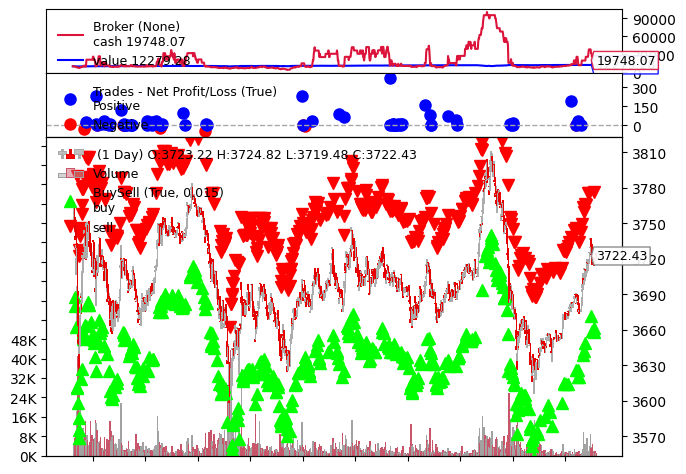

1400 0.1 :
<FINISH> Brokerage account: $12718.86


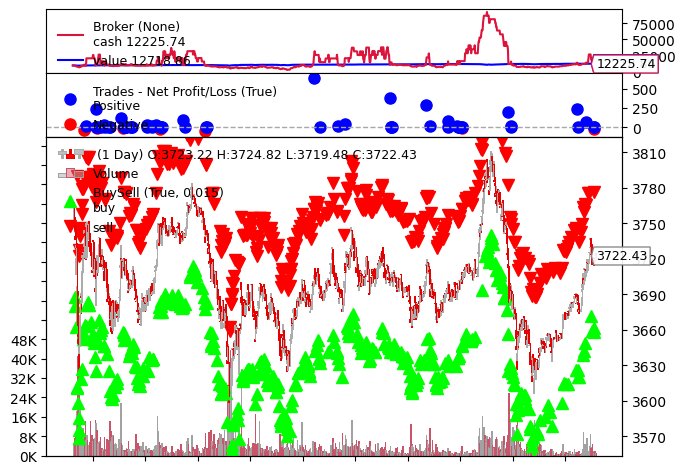

1400 0.5 :
<FINISH> Brokerage account: $15882.43


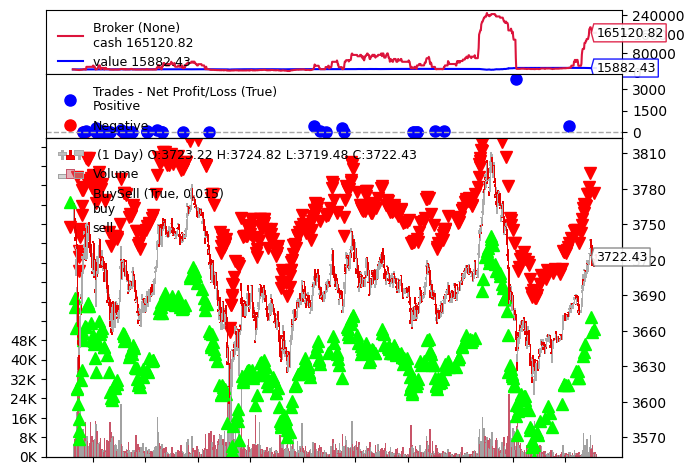

1400 1 :
<FINISH> Brokerage account: $13178.61


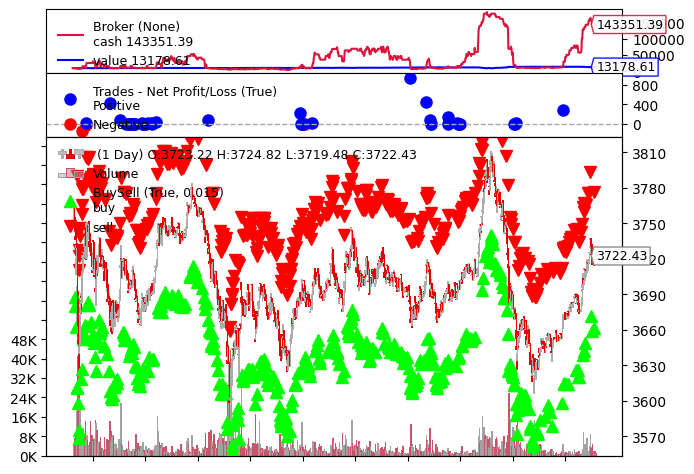

In [16]:
k_multipliers = [ 600 , 800 , 1000, 1200 , 1400]
risk_aversions = [ 0.01 , 0.05 , 0.1 , 0.5 , 1]

for k_multiplier in k_multipliers:
    for risk_aversion in risk_aversions:
        
        class MAstrategy(bt.Strategy):
            def __init__(self):
                self.orders = []

            def next(self):
                time = str_to_timestamp( str( self.datas[0].datetime.date() ) + " " + str( self.data.datetime.time() )   )  
                start_time = kline_full_df.iloc[1]['Datetime']
                end_time = kline_full_df.iloc[-1]['Datetime']
                
                if start_time >= time:
                    return
        
                if end_time <= time:
                    return
                
                ask_price_at_time = orderbook_df[orderbook_df["Datetime"] == smallest_timestamp_before(  time	)].iloc[0] ['askp0']
                bid_price_at_time = orderbook_df[orderbook_df["Datetime"] == smallest_timestamp_before(  time	)].iloc[0] ['bidp0']
                
                s = 0.5 * ( ask_price_at_time + bid_price_at_time )
        
                sigma = volatility(kline_full_df , time)
        
                k = trading_intensity(orderbook_df , time)
        
                eta = 0.005
                
                gamma = risk_aversion
        
                qt = self.position.size
                
                AS = AvellanedaStoikov(s, qt, sigma, gamma, k * k_multiplier , eta , 1 , time_percentage(time) )
                
        
                if k > 0 :
                    for order in self.orders:
                        self.broker.cancel(order)
                    #self.log('Buy Limit Create, %.2f' % AS.optimal_bid())
                    order = self.buy(exectype=Order.Limit, price=AS.optimal_bid() , size=AS.bid_size(qt , self.stats.broker.value[0] * 0.5) )
                    #self.log('Sell Limit Create, %.2f' % AS.optimal_ask())
                    order = self.sell(exectype=Order.Limit, price=AS.optimal_ask() , size=AS.bid_size(qt , self.stats.broker.value[0] * 0.5) )
                    #self.log('Account Value, %.2f' % self.stats.broker.value[0] )
 
        	# outputting information
            def log(self, txt):
                dt = str( self.datas[0].datetime.date() ) + " " + str( self.data.datetime.time() )
                print('%s, %s' % (dt, txt))

            '''
            def notify_order(self, order):
                if order.status == order.Completed:
                    if order.isbuy():
                        self.log(
                        "Executed Limit BUY (Price: %.2f, Value: %.2f, Commission %.2f)" %
                        (order.executed.price, order.executed.value, order.executed.comm))
                    else:
                        self.log(
                        "Executed Limit SELL (Price: %.2f, Value: %.2f, Commission %.2f)" %
                        (order.executed.price, order.executed.value, order.executed.comm))
                    self.bar_executed = len(self)
                elif order.status in [order.Canceled, order.Margin, order.Rejected]:
                    self.log("Order was canceled/margin/rejected")
            '''
        
        cerebro = bt.Cerebro()
        cerebro.addstrategy(MAstrategy)
        cerebro.broker.setcash(10000)
        cerebro.broker.setcommission(commission=0.000 , leverage=10)
        data = bt.feeds.PandasData(dataname=kline_next_df )
        cerebro.adddata(data)

        print( k_multiplier , risk_aversion , ":" )
        cerebro.run()
        print('<FINISH> Brokerage account: $%.2f' % cerebro.broker.getvalue())
        %matplotlib inline
        # Plot the strategy
        img = cerebro.plot(style='candlestick',loc='grey', grid=False, iplot=False) #You can leave inside the paranthesis empty
        
        img[0][0].savefig('Data/plot_k_multiplier{}_risk_aversion{}.png'.format(k_multiplier , risk_aversion))
